In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision.models as models
from torchvision import transforms

from PIL import Image
import numpy as np
import pandas as pd
import os

class FlowerDataset(Dataset):
    def __init__(self, image_dir, image_paths, label_file, transform=None):
        self.image_dir = image_dir
        self.labels = np.load(label_file)
        self.image_label_pairs = self._load_paths(image_paths)
        self.transform = transform
        
    def train_val_test_split(self, train_ratio, val_ratio):
        dataset_length = len(self.image_label_pairs)
        train_length = int(train_ratio * dataset_length)
        val_length = int(val_ratio * dataset_length)
        test_length = len(self) - train_length - val_length
        splits = [train_length, val_length, test_length]
        return random_split(self, splits)
        
    def _load_paths(self, file_path):
        """
        params:  file_path, a path pointing to where the image paths are stored.
        returns: dictionary with keys 'full_image_path', and values 'label'
        """
        split_set = {}
        with open(file_path) as f:
            lines = f.readlines()
            num_lines = len(lines)
            assert(num_lines == len(self.labels))
            for line_num in range(num_lines):
                full_image_path = os.path.join(self.image_dir, lines[line_num].strip('\n'))
                split_set[full_image_path] = self.labels[line_num]
        return pd.DataFrame.from_dict(split_set, orient='index')
        
    def _load_image(self, image_path):
        img = Image.open(image_path)
        img.load()
        img = np.array(img)
        if len(img.shape) == 2:
            img = np.expand_dims(img, 2)
            img = np.repeat(img, 3, 2)
        return Image.fromarray(img)
        
    def __len__(self):
        return len(self.image_label_pairs)
    
    def __getitem__(self, idx):
        # apply transforms
        image_path = self.image_label_pairs.index[idx]
        image = self._load_image(image_path)
        if self.transform is not None:
            image = self.transform(image)
        label = self.labels[idx]
        return {'image': image,
                'label': label}
    
transform = transforms.Compose([transforms.CenterCrop(200), transforms.ToTensor()])
dataset = FlowerDataset('data', 'image_paths.txt', 'labels.npy', transform=transform)
train_set, val_set, test_set = dataset.train_val_test_split(0.7, 0.1)


train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=4)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_losses = []
    for idx, batch in enumerate(train_loader):
        data, target = batch['image'].to(device), batch['label'].long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = CE(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        print('Epoch: {}, Samples: {}/{}, Loss: {}'.format(epoch, idx*batch_size,
                                                           len(train_loader)*batch_size,
                                                           loss.item()))
    train_loss = torch.mean(torch.tensor(train_losses))
    print('\nEpoch: {}'.format(epoch))
    print('Training set: Average loss: {:.4f}'.format(train_loss))
    
    return train_loss

def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for _, batch in enumerate(val_loader):
            data, target = batch['image'].to(device), batch['label'].long().to(device)
            output = model(data)
            
            # compute the batch loss
            batch_loss = CE(output, target).item()
            val_loss += batch_loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # divide by the number of batches of batch size 32
    # get the average validation over all bins
    val_loss /= len(val_loader)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    return val_loss

DATA_DIRECTORY = 'data/'
use_cuda = 1
batch_size = 32
num_epochs = 50
learning_rate = 1e-3

device = torch.device("cuda" if use_cuda else "cpu")
model = models.resnet18(num_classes=102).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
CE = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    val_loss = validate(model, device, val_loader)

    if (len(val_losses) > 0) and (val_loss < min(val_losses)):
        torch.save(model.state_dict(), "best_model.pt")
        print("Saving model (epoch {}) with lowest validation loss: {}"
              .format(epoch, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

print("Training and validation complete.")

Epoch: 1, Samples: 0/5760, Loss: 4.556001663208008
Epoch: 1, Samples: 32/5760, Loss: 4.807998180389404
Epoch: 1, Samples: 64/5760, Loss: 4.754427433013916
Epoch: 1, Samples: 96/5760, Loss: 4.662336826324463
Epoch: 1, Samples: 128/5760, Loss: 4.687515735626221
Epoch: 1, Samples: 160/5760, Loss: 4.847537040710449
Epoch: 1, Samples: 192/5760, Loss: 4.754984378814697
Epoch: 1, Samples: 224/5760, Loss: 4.707015037536621
Epoch: 1, Samples: 256/5760, Loss: 4.539435386657715
Epoch: 1, Samples: 288/5760, Loss: 4.579208850860596
Epoch: 1, Samples: 320/5760, Loss: 4.562300205230713
Epoch: 1, Samples: 352/5760, Loss: 4.760418891906738
Epoch: 1, Samples: 384/5760, Loss: 4.568358898162842
Epoch: 1, Samples: 416/5760, Loss: 4.677227973937988
Epoch: 1, Samples: 448/5760, Loss: 4.6275129318237305
Epoch: 1, Samples: 480/5760, Loss: 4.637516975402832
Epoch: 1, Samples: 512/5760, Loss: 4.7410197257995605
Epoch: 1, Samples: 544/5760, Loss: 4.494808197021484
Epoch: 1, Samples: 576/5760, Loss: 4.241174697875

Epoch: 1, Samples: 4896/5760, Loss: 3.9042606353759766
Epoch: 1, Samples: 4928/5760, Loss: 4.04185152053833
Epoch: 1, Samples: 4960/5760, Loss: 4.2513108253479
Epoch: 1, Samples: 4992/5760, Loss: 3.9645705223083496
Epoch: 1, Samples: 5024/5760, Loss: 4.2627058029174805
Epoch: 1, Samples: 5056/5760, Loss: 4.0413737297058105
Epoch: 1, Samples: 5088/5760, Loss: 4.150453090667725
Epoch: 1, Samples: 5120/5760, Loss: 3.8399953842163086
Epoch: 1, Samples: 5152/5760, Loss: 3.6247997283935547
Epoch: 1, Samples: 5184/5760, Loss: 3.7275891304016113
Epoch: 1, Samples: 5216/5760, Loss: 3.7734262943267822
Epoch: 1, Samples: 5248/5760, Loss: 3.8946216106414795
Epoch: 1, Samples: 5280/5760, Loss: 3.6527299880981445
Epoch: 1, Samples: 5312/5760, Loss: 3.6566922664642334
Epoch: 1, Samples: 5344/5760, Loss: 3.814462184906006
Epoch: 1, Samples: 5376/5760, Loss: 3.797210216522217
Epoch: 1, Samples: 5408/5760, Loss: 3.6923487186431885
Epoch: 1, Samples: 5440/5760, Loss: 3.8697147369384766
Epoch: 1, Samples:

Epoch: 2, Samples: 3904/5760, Loss: 3.300143003463745
Epoch: 2, Samples: 3936/5760, Loss: 3.5177464485168457
Epoch: 2, Samples: 3968/5760, Loss: 2.8914601802825928
Epoch: 2, Samples: 4000/5760, Loss: 3.719750165939331
Epoch: 2, Samples: 4032/5760, Loss: 3.3223493099212646
Epoch: 2, Samples: 4064/5760, Loss: 3.5301294326782227
Epoch: 2, Samples: 4096/5760, Loss: 3.3233845233917236
Epoch: 2, Samples: 4128/5760, Loss: 3.2264957427978516
Epoch: 2, Samples: 4160/5760, Loss: 3.459146022796631
Epoch: 2, Samples: 4192/5760, Loss: 3.5317118167877197
Epoch: 2, Samples: 4224/5760, Loss: 3.4459304809570312
Epoch: 2, Samples: 4256/5760, Loss: 3.774745225906372
Epoch: 2, Samples: 4288/5760, Loss: 3.3446044921875
Epoch: 2, Samples: 4320/5760, Loss: 3.7271814346313477
Epoch: 2, Samples: 4352/5760, Loss: 3.1245148181915283
Epoch: 2, Samples: 4384/5760, Loss: 3.1806492805480957
Epoch: 2, Samples: 4416/5760, Loss: 3.368650436401367
Epoch: 2, Samples: 4448/5760, Loss: 2.979912757873535
Epoch: 2, Samples: 

Epoch: 3, Samples: 2880/5760, Loss: 3.1219582557678223
Epoch: 3, Samples: 2912/5760, Loss: 3.2512362003326416
Epoch: 3, Samples: 2944/5760, Loss: 3.2126340866088867
Epoch: 3, Samples: 2976/5760, Loss: 3.2187273502349854
Epoch: 3, Samples: 3008/5760, Loss: 2.7114851474761963
Epoch: 3, Samples: 3040/5760, Loss: 3.584916830062866
Epoch: 3, Samples: 3072/5760, Loss: 3.082462787628174
Epoch: 3, Samples: 3104/5760, Loss: 2.9165618419647217
Epoch: 3, Samples: 3136/5760, Loss: 3.405723810195923
Epoch: 3, Samples: 3168/5760, Loss: 3.1424598693847656
Epoch: 3, Samples: 3200/5760, Loss: 3.163007974624634
Epoch: 3, Samples: 3232/5760, Loss: 2.882164239883423
Epoch: 3, Samples: 3264/5760, Loss: 3.170677661895752
Epoch: 3, Samples: 3296/5760, Loss: 3.3496575355529785
Epoch: 3, Samples: 3328/5760, Loss: 3.184298515319824
Epoch: 3, Samples: 3360/5760, Loss: 3.0110490322113037
Epoch: 3, Samples: 3392/5760, Loss: 3.734663724899292
Epoch: 3, Samples: 3424/5760, Loss: 3.760154962539673
Epoch: 3, Samples: 

Epoch: 4, Samples: 1856/5760, Loss: 3.0655863285064697
Epoch: 4, Samples: 1888/5760, Loss: 3.0183892250061035
Epoch: 4, Samples: 1920/5760, Loss: 2.461433172225952
Epoch: 4, Samples: 1952/5760, Loss: 2.8744583129882812
Epoch: 4, Samples: 1984/5760, Loss: 3.0140933990478516
Epoch: 4, Samples: 2016/5760, Loss: 2.9616477489471436
Epoch: 4, Samples: 2048/5760, Loss: 2.5018625259399414
Epoch: 4, Samples: 2080/5760, Loss: 2.7958719730377197
Epoch: 4, Samples: 2112/5760, Loss: 2.865875482559204
Epoch: 4, Samples: 2144/5760, Loss: 3.2129666805267334
Epoch: 4, Samples: 2176/5760, Loss: 2.6496193408966064
Epoch: 4, Samples: 2208/5760, Loss: 2.8483567237854004
Epoch: 4, Samples: 2240/5760, Loss: 2.8374438285827637
Epoch: 4, Samples: 2272/5760, Loss: 2.8167760372161865
Epoch: 4, Samples: 2304/5760, Loss: 2.7389330863952637
Epoch: 4, Samples: 2336/5760, Loss: 3.2449002265930176
Epoch: 4, Samples: 2368/5760, Loss: 3.108225107192993
Epoch: 4, Samples: 2400/5760, Loss: 3.3149452209472656
Epoch: 4, Sam

Epoch: 5, Samples: 832/5760, Loss: 2.909635305404663
Epoch: 5, Samples: 864/5760, Loss: 2.9611287117004395
Epoch: 5, Samples: 896/5760, Loss: 2.747267723083496
Epoch: 5, Samples: 928/5760, Loss: 3.1059653759002686
Epoch: 5, Samples: 960/5760, Loss: 3.1615381240844727
Epoch: 5, Samples: 992/5760, Loss: 2.82917857170105
Epoch: 5, Samples: 1024/5760, Loss: 2.7060019969940186
Epoch: 5, Samples: 1056/5760, Loss: 2.8469552993774414
Epoch: 5, Samples: 1088/5760, Loss: 3.031766891479492
Epoch: 5, Samples: 1120/5760, Loss: 2.5951027870178223
Epoch: 5, Samples: 1152/5760, Loss: 2.3759922981262207
Epoch: 5, Samples: 1184/5760, Loss: 2.609998941421509
Epoch: 5, Samples: 1216/5760, Loss: 2.7445664405822754
Epoch: 5, Samples: 1248/5760, Loss: 2.8977315425872803
Epoch: 5, Samples: 1280/5760, Loss: 2.954219102859497
Epoch: 5, Samples: 1312/5760, Loss: 2.584742784500122
Epoch: 5, Samples: 1344/5760, Loss: 3.5395002365112305
Epoch: 5, Samples: 1376/5760, Loss: 3.071563959121704
Epoch: 5, Samples: 1408/5

Epoch: 5, Samples: 5664/5760, Loss: 2.724876642227173
Epoch: 5, Samples: 5696/5760, Loss: 2.6027870178222656
Epoch: 5, Samples: 5728/5760, Loss: 3.361424446105957

Epoch: 5
Training set: Average loss: 2.7842
Validation set: Average loss: 3.1761, Accuracy: 187/818 (23%)
Epoch: 6, Samples: 0/5760, Loss: 2.4344515800476074
Epoch: 6, Samples: 32/5760, Loss: 3.0856099128723145
Epoch: 6, Samples: 64/5760, Loss: 2.587679862976074
Epoch: 6, Samples: 96/5760, Loss: 2.2801973819732666
Epoch: 6, Samples: 128/5760, Loss: 2.8249897956848145
Epoch: 6, Samples: 160/5760, Loss: 2.5254900455474854
Epoch: 6, Samples: 192/5760, Loss: 2.5074551105499268
Epoch: 6, Samples: 224/5760, Loss: 2.3055121898651123
Epoch: 6, Samples: 256/5760, Loss: 2.5563855171203613
Epoch: 6, Samples: 288/5760, Loss: 3.0244858264923096
Epoch: 6, Samples: 320/5760, Loss: 2.6709976196289062
Epoch: 6, Samples: 352/5760, Loss: 3.0514636039733887
Epoch: 6, Samples: 384/5760, Loss: 2.4978628158569336
Epoch: 6, Samples: 416/5760, Loss:

Epoch: 6, Samples: 4704/5760, Loss: 2.8705098628997803
Epoch: 6, Samples: 4736/5760, Loss: 2.7785842418670654
Epoch: 6, Samples: 4768/5760, Loss: 2.483412504196167
Epoch: 6, Samples: 4800/5760, Loss: 2.3265902996063232
Epoch: 6, Samples: 4832/5760, Loss: 2.427028179168701
Epoch: 6, Samples: 4864/5760, Loss: 3.0037198066711426
Epoch: 6, Samples: 4896/5760, Loss: 2.952378511428833
Epoch: 6, Samples: 4928/5760, Loss: 3.152470350265503
Epoch: 6, Samples: 4960/5760, Loss: 2.736105442047119
Epoch: 6, Samples: 4992/5760, Loss: 2.3144443035125732
Epoch: 6, Samples: 5024/5760, Loss: 2.5982093811035156
Epoch: 6, Samples: 5056/5760, Loss: 2.5190298557281494
Epoch: 6, Samples: 5088/5760, Loss: 2.859984874725342
Epoch: 6, Samples: 5120/5760, Loss: 2.909430980682373
Epoch: 6, Samples: 5152/5760, Loss: 2.4807746410369873
Epoch: 6, Samples: 5184/5760, Loss: 2.7575039863586426
Epoch: 6, Samples: 5216/5760, Loss: 2.389739513397217
Epoch: 6, Samples: 5248/5760, Loss: 2.4125773906707764
Epoch: 6, Samples:

Epoch: 7, Samples: 3680/5760, Loss: 2.0376391410827637
Epoch: 7, Samples: 3712/5760, Loss: 2.6118288040161133
Epoch: 7, Samples: 3744/5760, Loss: 2.4621455669403076
Epoch: 7, Samples: 3776/5760, Loss: 2.4477458000183105
Epoch: 7, Samples: 3808/5760, Loss: 2.5941953659057617
Epoch: 7, Samples: 3840/5760, Loss: 2.4220685958862305
Epoch: 7, Samples: 3872/5760, Loss: 2.2125391960144043
Epoch: 7, Samples: 3904/5760, Loss: 2.7410707473754883
Epoch: 7, Samples: 3936/5760, Loss: 2.5608980655670166
Epoch: 7, Samples: 3968/5760, Loss: 2.4778409004211426
Epoch: 7, Samples: 4000/5760, Loss: 2.7518038749694824
Epoch: 7, Samples: 4032/5760, Loss: 2.558506488800049
Epoch: 7, Samples: 4064/5760, Loss: 2.4217729568481445
Epoch: 7, Samples: 4096/5760, Loss: 2.217268943786621
Epoch: 7, Samples: 4128/5760, Loss: 2.5589613914489746
Epoch: 7, Samples: 4160/5760, Loss: 2.3015804290771484
Epoch: 7, Samples: 4192/5760, Loss: 2.4432976245880127
Epoch: 7, Samples: 4224/5760, Loss: 1.9358853101730347
Epoch: 7, Sa

Epoch: 8, Samples: 2656/5760, Loss: 2.5283570289611816
Epoch: 8, Samples: 2688/5760, Loss: 2.6920552253723145
Epoch: 8, Samples: 2720/5760, Loss: 2.062702178955078
Epoch: 8, Samples: 2752/5760, Loss: 1.978890299797058
Epoch: 8, Samples: 2784/5760, Loss: 2.150510787963867
Epoch: 8, Samples: 2816/5760, Loss: 2.455759048461914
Epoch: 8, Samples: 2848/5760, Loss: 2.3262360095977783
Epoch: 8, Samples: 2880/5760, Loss: 2.076261520385742
Epoch: 8, Samples: 2912/5760, Loss: 2.4372689723968506
Epoch: 8, Samples: 2944/5760, Loss: 2.4396021366119385
Epoch: 8, Samples: 2976/5760, Loss: 2.971327543258667
Epoch: 8, Samples: 3008/5760, Loss: 2.321545124053955
Epoch: 8, Samples: 3040/5760, Loss: 2.6167542934417725
Epoch: 8, Samples: 3072/5760, Loss: 2.421415090560913
Epoch: 8, Samples: 3104/5760, Loss: 2.597032070159912
Epoch: 8, Samples: 3136/5760, Loss: 2.6051902770996094
Epoch: 8, Samples: 3168/5760, Loss: 2.4698848724365234
Epoch: 8, Samples: 3200/5760, Loss: 2.4272971153259277
Epoch: 8, Samples: 

Epoch: 9, Samples: 1664/5760, Loss: 2.1623103618621826
Epoch: 9, Samples: 1696/5760, Loss: 2.0610640048980713
Epoch: 9, Samples: 1728/5760, Loss: 2.3543736934661865
Epoch: 9, Samples: 1760/5760, Loss: 2.3368782997131348
Epoch: 9, Samples: 1792/5760, Loss: 1.8727778196334839
Epoch: 9, Samples: 1824/5760, Loss: 2.3884143829345703
Epoch: 9, Samples: 1856/5760, Loss: 2.1381115913391113
Epoch: 9, Samples: 1888/5760, Loss: 2.4067792892456055
Epoch: 9, Samples: 1920/5760, Loss: 2.855273723602295
Epoch: 9, Samples: 1952/5760, Loss: 2.8611292839050293
Epoch: 9, Samples: 1984/5760, Loss: 2.253412961959839
Epoch: 9, Samples: 2016/5760, Loss: 2.039872884750366
Epoch: 9, Samples: 2048/5760, Loss: 2.19783353805542
Epoch: 9, Samples: 2080/5760, Loss: 2.2351982593536377
Epoch: 9, Samples: 2112/5760, Loss: 2.3991100788116455
Epoch: 9, Samples: 2144/5760, Loss: 2.190955400466919
Epoch: 9, Samples: 2176/5760, Loss: 2.158809185028076
Epoch: 9, Samples: 2208/5760, Loss: 1.8287014961242676
Epoch: 9, Samples

Epoch: 10, Samples: 608/5760, Loss: 2.299004077911377
Epoch: 10, Samples: 640/5760, Loss: 2.7201883792877197
Epoch: 10, Samples: 672/5760, Loss: 2.082369089126587
Epoch: 10, Samples: 704/5760, Loss: 1.997148871421814
Epoch: 10, Samples: 736/5760, Loss: 2.022599458694458
Epoch: 10, Samples: 768/5760, Loss: 2.373727560043335
Epoch: 10, Samples: 800/5760, Loss: 2.2798190116882324
Epoch: 10, Samples: 832/5760, Loss: 2.486157178878784
Epoch: 10, Samples: 864/5760, Loss: 2.328449249267578
Epoch: 10, Samples: 896/5760, Loss: 2.1012609004974365
Epoch: 10, Samples: 928/5760, Loss: 2.0102806091308594
Epoch: 10, Samples: 960/5760, Loss: 2.1800663471221924
Epoch: 10, Samples: 992/5760, Loss: 1.954963207244873
Epoch: 10, Samples: 1024/5760, Loss: 2.125729560852051
Epoch: 10, Samples: 1056/5760, Loss: 2.608816146850586
Epoch: 10, Samples: 1088/5760, Loss: 2.599696397781372
Epoch: 10, Samples: 1120/5760, Loss: 2.3587677478790283
Epoch: 10, Samples: 1152/5760, Loss: 2.3640339374542236
Epoch: 10, Sampl

Epoch: 10, Samples: 5344/5760, Loss: 2.1856088638305664
Epoch: 10, Samples: 5376/5760, Loss: 2.5129730701446533
Epoch: 10, Samples: 5408/5760, Loss: 2.421226978302002
Epoch: 10, Samples: 5440/5760, Loss: 2.0561435222625732
Epoch: 10, Samples: 5472/5760, Loss: 2.657179594039917
Epoch: 10, Samples: 5504/5760, Loss: 2.117480993270874
Epoch: 10, Samples: 5536/5760, Loss: 2.035529136657715
Epoch: 10, Samples: 5568/5760, Loss: 1.6797447204589844
Epoch: 10, Samples: 5600/5760, Loss: 1.803661584854126
Epoch: 10, Samples: 5632/5760, Loss: 2.1347527503967285
Epoch: 10, Samples: 5664/5760, Loss: 2.2678654193878174
Epoch: 10, Samples: 5696/5760, Loss: 2.327617645263672
Epoch: 10, Samples: 5728/5760, Loss: 2.235200881958008

Epoch: 10
Training set: Average loss: 2.1781
Validation set: Average loss: 2.2295, Accuracy: 350/818 (43%)
Saving model (epoch 10) with lowest validation loss: 2.229487180709839
Epoch: 11, Samples: 0/5760, Loss: 1.953113079071045
Epoch: 11, Samples: 32/5760, Loss: 2.24157094955

Epoch: 11, Samples: 4224/5760, Loss: 2.046588659286499
Epoch: 11, Samples: 4256/5760, Loss: 1.3786967992782593
Epoch: 11, Samples: 4288/5760, Loss: 1.9213570356369019
Epoch: 11, Samples: 4320/5760, Loss: 2.6073875427246094
Epoch: 11, Samples: 4352/5760, Loss: 1.9888873100280762
Epoch: 11, Samples: 4384/5760, Loss: 2.051579713821411
Epoch: 11, Samples: 4416/5760, Loss: 2.2275848388671875
Epoch: 11, Samples: 4448/5760, Loss: 1.734865427017212
Epoch: 11, Samples: 4480/5760, Loss: 1.6226189136505127
Epoch: 11, Samples: 4512/5760, Loss: 2.4105112552642822
Epoch: 11, Samples: 4544/5760, Loss: 2.1184096336364746
Epoch: 11, Samples: 4576/5760, Loss: 1.9088726043701172
Epoch: 11, Samples: 4608/5760, Loss: 2.0561914443969727
Epoch: 11, Samples: 4640/5760, Loss: 1.880398154258728
Epoch: 11, Samples: 4672/5760, Loss: 1.899340271949768
Epoch: 11, Samples: 4704/5760, Loss: 2.1558284759521484
Epoch: 11, Samples: 4736/5760, Loss: 2.224109649658203
Epoch: 11, Samples: 4768/5760, Loss: 2.415642261505127

Epoch: 12, Samples: 3136/5760, Loss: 1.647549033164978
Epoch: 12, Samples: 3168/5760, Loss: 1.8766212463378906
Epoch: 12, Samples: 3200/5760, Loss: 1.6953147649765015
Epoch: 12, Samples: 3232/5760, Loss: 1.6764812469482422
Epoch: 12, Samples: 3264/5760, Loss: 2.3250889778137207
Epoch: 12, Samples: 3296/5760, Loss: 2.0679831504821777
Epoch: 12, Samples: 3328/5760, Loss: 2.0029141902923584
Epoch: 12, Samples: 3360/5760, Loss: 1.886782169342041
Epoch: 12, Samples: 3392/5760, Loss: 1.8455568552017212
Epoch: 12, Samples: 3424/5760, Loss: 2.003485918045044
Epoch: 12, Samples: 3456/5760, Loss: 1.9677449464797974
Epoch: 12, Samples: 3488/5760, Loss: 1.7074592113494873
Epoch: 12, Samples: 3520/5760, Loss: 2.069706678390503
Epoch: 12, Samples: 3552/5760, Loss: 1.8565587997436523
Epoch: 12, Samples: 3584/5760, Loss: 1.814156174659729
Epoch: 12, Samples: 3616/5760, Loss: 2.3643763065338135
Epoch: 12, Samples: 3648/5760, Loss: 2.2828993797302246
Epoch: 12, Samples: 3680/5760, Loss: 2.00464463233947

Epoch: 13, Samples: 2016/5760, Loss: 1.534727692604065
Epoch: 13, Samples: 2048/5760, Loss: 2.197338104248047
Epoch: 13, Samples: 2080/5760, Loss: 1.5042582750320435
Epoch: 13, Samples: 2112/5760, Loss: 1.8365765810012817
Epoch: 13, Samples: 2144/5760, Loss: 1.8963079452514648
Epoch: 13, Samples: 2176/5760, Loss: 1.4729136228561401
Epoch: 13, Samples: 2208/5760, Loss: 1.836929202079773
Epoch: 13, Samples: 2240/5760, Loss: 2.1586148738861084
Epoch: 13, Samples: 2272/5760, Loss: 1.5941252708435059
Epoch: 13, Samples: 2304/5760, Loss: 1.8926215171813965
Epoch: 13, Samples: 2336/5760, Loss: 1.816311240196228
Epoch: 13, Samples: 2368/5760, Loss: 2.1074206829071045
Epoch: 13, Samples: 2400/5760, Loss: 1.4845540523529053
Epoch: 13, Samples: 2432/5760, Loss: 1.9379181861877441
Epoch: 13, Samples: 2464/5760, Loss: 1.530747890472412
Epoch: 13, Samples: 2496/5760, Loss: 1.8063037395477295
Epoch: 13, Samples: 2528/5760, Loss: 1.5065486431121826
Epoch: 13, Samples: 2560/5760, Loss: 1.87674677371978

Epoch: 14, Samples: 960/5760, Loss: 2.121288299560547
Epoch: 14, Samples: 992/5760, Loss: 2.400543689727783
Epoch: 14, Samples: 1024/5760, Loss: 1.7144964933395386
Epoch: 14, Samples: 1056/5760, Loss: 1.9817688465118408
Epoch: 14, Samples: 1088/5760, Loss: 2.0600168704986572
Epoch: 14, Samples: 1120/5760, Loss: 2.5658187866210938
Epoch: 14, Samples: 1152/5760, Loss: 1.619140625
Epoch: 14, Samples: 1184/5760, Loss: 1.602161169052124
Epoch: 14, Samples: 1216/5760, Loss: 1.9704395532608032
Epoch: 14, Samples: 1248/5760, Loss: 1.8704993724822998
Epoch: 14, Samples: 1280/5760, Loss: 1.811090111732483
Epoch: 14, Samples: 1312/5760, Loss: 1.8436384201049805
Epoch: 14, Samples: 1344/5760, Loss: 2.115649938583374
Epoch: 14, Samples: 1376/5760, Loss: 2.0953595638275146
Epoch: 14, Samples: 1408/5760, Loss: 1.6249592304229736
Epoch: 14, Samples: 1440/5760, Loss: 1.8604321479797363
Epoch: 14, Samples: 1472/5760, Loss: 1.8794441223144531
Epoch: 14, Samples: 1504/5760, Loss: 1.8537302017211914
Epoch:

Epoch: 14, Samples: 5696/5760, Loss: 2.1109061241149902
Epoch: 14, Samples: 5728/5760, Loss: 2.9917659759521484

Epoch: 14
Training set: Average loss: 1.8296
Validation set: Average loss: 2.3706, Accuracy: 330/818 (40%)
Epoch: 15, Samples: 0/5760, Loss: 1.732187271118164
Epoch: 15, Samples: 32/5760, Loss: 1.5324273109436035
Epoch: 15, Samples: 64/5760, Loss: 2.251075029373169
Epoch: 15, Samples: 96/5760, Loss: 1.897691011428833
Epoch: 15, Samples: 128/5760, Loss: 1.6945065259933472
Epoch: 15, Samples: 160/5760, Loss: 1.501399040222168
Epoch: 15, Samples: 192/5760, Loss: 1.7338589429855347
Epoch: 15, Samples: 224/5760, Loss: 2.262721538543701
Epoch: 15, Samples: 256/5760, Loss: 1.6953985691070557
Epoch: 15, Samples: 288/5760, Loss: 1.6809202432632446
Epoch: 15, Samples: 320/5760, Loss: 1.5691817998886108
Epoch: 15, Samples: 352/5760, Loss: 1.6081212759017944
Epoch: 15, Samples: 384/5760, Loss: 1.509387731552124
Epoch: 15, Samples: 416/5760, Loss: 2.1270716190338135
Epoch: 15, Samples: 4

Epoch: 15, Samples: 4608/5760, Loss: 1.7285740375518799
Epoch: 15, Samples: 4640/5760, Loss: 1.3232288360595703
Epoch: 15, Samples: 4672/5760, Loss: 1.8549648523330688
Epoch: 15, Samples: 4704/5760, Loss: 1.8785343170166016
Epoch: 15, Samples: 4736/5760, Loss: 1.5460383892059326
Epoch: 15, Samples: 4768/5760, Loss: 1.9070788621902466
Epoch: 15, Samples: 4800/5760, Loss: 1.5628365278244019
Epoch: 15, Samples: 4832/5760, Loss: 1.7125972509384155
Epoch: 15, Samples: 4864/5760, Loss: 1.6468418836593628
Epoch: 15, Samples: 4896/5760, Loss: 1.3200196027755737
Epoch: 15, Samples: 4928/5760, Loss: 1.3825231790542603
Epoch: 15, Samples: 4960/5760, Loss: 1.1973227262496948
Epoch: 15, Samples: 4992/5760, Loss: 1.59977126121521
Epoch: 15, Samples: 5024/5760, Loss: 2.275951385498047
Epoch: 15, Samples: 5056/5760, Loss: 1.7090905904769897
Epoch: 15, Samples: 5088/5760, Loss: 1.808107614517212
Epoch: 15, Samples: 5120/5760, Loss: 1.0857411623001099
Epoch: 15, Samples: 5152/5760, Loss: 1.5787698030471

Epoch: 16, Samples: 3488/5760, Loss: 1.5155150890350342
Epoch: 16, Samples: 3520/5760, Loss: 1.8325145244598389
Epoch: 16, Samples: 3552/5760, Loss: 1.5097676515579224
Epoch: 16, Samples: 3584/5760, Loss: 2.095449924468994
Epoch: 16, Samples: 3616/5760, Loss: 1.5750319957733154
Epoch: 16, Samples: 3648/5760, Loss: 1.5174399614334106
Epoch: 16, Samples: 3680/5760, Loss: 1.4152612686157227
Epoch: 16, Samples: 3712/5760, Loss: 1.7612491846084595
Epoch: 16, Samples: 3744/5760, Loss: 1.7654497623443604
Epoch: 16, Samples: 3776/5760, Loss: 1.7563257217407227
Epoch: 16, Samples: 3808/5760, Loss: 1.4015552997589111
Epoch: 16, Samples: 3840/5760, Loss: 2.305758476257324
Epoch: 16, Samples: 3872/5760, Loss: 1.4195393323898315
Epoch: 16, Samples: 3904/5760, Loss: 2.1733345985412598
Epoch: 16, Samples: 3936/5760, Loss: 1.3167905807495117
Epoch: 16, Samples: 3968/5760, Loss: 1.5100648403167725
Epoch: 16, Samples: 4000/5760, Loss: 1.5098450183868408
Epoch: 16, Samples: 4032/5760, Loss: 1.55327606201

Epoch: 17, Samples: 2368/5760, Loss: 1.3077553510665894
Epoch: 17, Samples: 2400/5760, Loss: 2.0488946437835693
Epoch: 17, Samples: 2432/5760, Loss: 1.7974413633346558
Epoch: 17, Samples: 2464/5760, Loss: 2.5106639862060547
Epoch: 17, Samples: 2496/5760, Loss: 1.528387188911438
Epoch: 17, Samples: 2528/5760, Loss: 1.2314471006393433
Epoch: 17, Samples: 2560/5760, Loss: 1.3051567077636719
Epoch: 17, Samples: 2592/5760, Loss: 1.2918977737426758
Epoch: 17, Samples: 2624/5760, Loss: 1.5797446966171265
Epoch: 17, Samples: 2656/5760, Loss: 1.7904309034347534
Epoch: 17, Samples: 2688/5760, Loss: 1.7598214149475098
Epoch: 17, Samples: 2720/5760, Loss: 1.5488331317901611
Epoch: 17, Samples: 2752/5760, Loss: 1.615858793258667
Epoch: 17, Samples: 2784/5760, Loss: 1.7777657508850098
Epoch: 17, Samples: 2816/5760, Loss: 1.6841014623641968
Epoch: 17, Samples: 2848/5760, Loss: 1.6854201555252075
Epoch: 17, Samples: 2880/5760, Loss: 1.2797869443893433
Epoch: 17, Samples: 2912/5760, Loss: 1.99566280841

Epoch: 18, Samples: 1280/5760, Loss: 1.609125018119812
Epoch: 18, Samples: 1312/5760, Loss: 1.4328728914260864
Epoch: 18, Samples: 1344/5760, Loss: 1.3525182008743286
Epoch: 18, Samples: 1376/5760, Loss: 1.364898681640625
Epoch: 18, Samples: 1408/5760, Loss: 1.1191420555114746
Epoch: 18, Samples: 1440/5760, Loss: 1.7398431301116943
Epoch: 18, Samples: 1472/5760, Loss: 1.1929247379302979
Epoch: 18, Samples: 1504/5760, Loss: 1.5456372499465942
Epoch: 18, Samples: 1536/5760, Loss: 1.3379175662994385
Epoch: 18, Samples: 1568/5760, Loss: 1.3877277374267578
Epoch: 18, Samples: 1600/5760, Loss: 2.1540987491607666
Epoch: 18, Samples: 1632/5760, Loss: 1.7795907258987427
Epoch: 18, Samples: 1664/5760, Loss: 1.7108161449432373
Epoch: 18, Samples: 1696/5760, Loss: 1.634100079536438
Epoch: 18, Samples: 1728/5760, Loss: 1.9648321866989136
Epoch: 18, Samples: 1760/5760, Loss: 1.6465610265731812
Epoch: 18, Samples: 1792/5760, Loss: 1.2653958797454834
Epoch: 18, Samples: 1824/5760, Loss: 1.578092455863

Epoch: 19, Samples: 192/5760, Loss: 1.72951340675354
Epoch: 19, Samples: 224/5760, Loss: 1.6760386228561401
Epoch: 19, Samples: 256/5760, Loss: 1.7304563522338867
Epoch: 19, Samples: 288/5760, Loss: 1.8174042701721191
Epoch: 19, Samples: 320/5760, Loss: 2.065816879272461
Epoch: 19, Samples: 352/5760, Loss: 1.4006725549697876
Epoch: 19, Samples: 384/5760, Loss: 1.491361141204834
Epoch: 19, Samples: 416/5760, Loss: 2.033696413040161
Epoch: 19, Samples: 448/5760, Loss: 1.5837593078613281
Epoch: 19, Samples: 480/5760, Loss: 1.665041446685791
Epoch: 19, Samples: 512/5760, Loss: 1.2737648487091064
Epoch: 19, Samples: 544/5760, Loss: 1.4551031589508057
Epoch: 19, Samples: 576/5760, Loss: 1.3711304664611816
Epoch: 19, Samples: 608/5760, Loss: 1.2809689044952393
Epoch: 19, Samples: 640/5760, Loss: 2.0948541164398193
Epoch: 19, Samples: 672/5760, Loss: 1.702958583831787
Epoch: 19, Samples: 704/5760, Loss: 1.4451254606246948
Epoch: 19, Samples: 736/5760, Loss: 1.3928093910217285
Epoch: 19, Sample

Epoch: 19, Samples: 4928/5760, Loss: 1.2931828498840332
Epoch: 19, Samples: 4960/5760, Loss: 1.6940504312515259
Epoch: 19, Samples: 4992/5760, Loss: 1.2833412885665894
Epoch: 19, Samples: 5024/5760, Loss: 1.6649259328842163
Epoch: 19, Samples: 5056/5760, Loss: 1.3676077127456665
Epoch: 19, Samples: 5088/5760, Loss: 1.2293742895126343
Epoch: 19, Samples: 5120/5760, Loss: 1.801966667175293
Epoch: 19, Samples: 5152/5760, Loss: 1.727636694908142
Epoch: 19, Samples: 5184/5760, Loss: 1.488801121711731
Epoch: 19, Samples: 5216/5760, Loss: 1.7815513610839844
Epoch: 19, Samples: 5248/5760, Loss: 1.3201096057891846
Epoch: 19, Samples: 5280/5760, Loss: 0.9434020519256592
Epoch: 19, Samples: 5312/5760, Loss: 1.6339408159255981
Epoch: 19, Samples: 5344/5760, Loss: 1.359920859336853
Epoch: 19, Samples: 5376/5760, Loss: 1.9635372161865234
Epoch: 19, Samples: 5408/5760, Loss: 1.1836031675338745
Epoch: 19, Samples: 5440/5760, Loss: 1.213452696800232
Epoch: 19, Samples: 5472/5760, Loss: 1.74333071708679

Epoch: 20, Samples: 3808/5760, Loss: 1.236235499382019
Epoch: 20, Samples: 3840/5760, Loss: 1.4102282524108887
Epoch: 20, Samples: 3872/5760, Loss: 1.6822608709335327
Epoch: 20, Samples: 3904/5760, Loss: 1.501030445098877
Epoch: 20, Samples: 3936/5760, Loss: 1.4788378477096558
Epoch: 20, Samples: 3968/5760, Loss: 1.035670280456543
Epoch: 20, Samples: 4000/5760, Loss: 1.569867491722107
Epoch: 20, Samples: 4032/5760, Loss: 1.7681058645248413
Epoch: 20, Samples: 4064/5760, Loss: 1.4882690906524658
Epoch: 20, Samples: 4096/5760, Loss: 1.5307129621505737
Epoch: 20, Samples: 4128/5760, Loss: 1.5014252662658691
Epoch: 20, Samples: 4160/5760, Loss: 1.3055168390274048
Epoch: 20, Samples: 4192/5760, Loss: 1.4157297611236572
Epoch: 20, Samples: 4224/5760, Loss: 1.6561022996902466
Epoch: 20, Samples: 4256/5760, Loss: 1.5289769172668457
Epoch: 20, Samples: 4288/5760, Loss: 1.5162677764892578
Epoch: 20, Samples: 4320/5760, Loss: 1.422882318496704
Epoch: 20, Samples: 4352/5760, Loss: 1.45613789558410

Epoch: 21, Samples: 2720/5760, Loss: 1.4655582904815674
Epoch: 21, Samples: 2752/5760, Loss: 1.5567761659622192
Epoch: 21, Samples: 2784/5760, Loss: 2.147684097290039
Epoch: 21, Samples: 2816/5760, Loss: 1.3637540340423584
Epoch: 21, Samples: 2848/5760, Loss: 1.2771189212799072
Epoch: 21, Samples: 2880/5760, Loss: 1.0818878412246704
Epoch: 21, Samples: 2912/5760, Loss: 1.3070145845413208
Epoch: 21, Samples: 2944/5760, Loss: 1.2509865760803223
Epoch: 21, Samples: 2976/5760, Loss: 1.8003003597259521
Epoch: 21, Samples: 3008/5760, Loss: 1.760238528251648
Epoch: 21, Samples: 3040/5760, Loss: 1.738271951675415
Epoch: 21, Samples: 3072/5760, Loss: 0.9274934530258179
Epoch: 21, Samples: 3104/5760, Loss: 1.176619529724121
Epoch: 21, Samples: 3136/5760, Loss: 1.579709529876709
Epoch: 21, Samples: 3168/5760, Loss: 1.1980807781219482
Epoch: 21, Samples: 3200/5760, Loss: 1.7319269180297852
Epoch: 21, Samples: 3232/5760, Loss: 1.2186217308044434
Epoch: 21, Samples: 3264/5760, Loss: 1.52914762496948

Epoch: 22, Samples: 1632/5760, Loss: 1.3590730428695679
Epoch: 22, Samples: 1664/5760, Loss: 1.1223911046981812
Epoch: 22, Samples: 1696/5760, Loss: 1.3361971378326416
Epoch: 22, Samples: 1728/5760, Loss: 1.0001435279846191
Epoch: 22, Samples: 1760/5760, Loss: 1.0469403266906738
Epoch: 22, Samples: 1792/5760, Loss: 1.4352959394454956
Epoch: 22, Samples: 1824/5760, Loss: 1.4058455228805542
Epoch: 22, Samples: 1856/5760, Loss: 1.1371442079544067
Epoch: 22, Samples: 1888/5760, Loss: 1.7421777248382568
Epoch: 22, Samples: 1920/5760, Loss: 1.2064623832702637
Epoch: 22, Samples: 1952/5760, Loss: 1.2822926044464111
Epoch: 22, Samples: 1984/5760, Loss: 1.3111183643341064
Epoch: 22, Samples: 2016/5760, Loss: 1.1070224046707153
Epoch: 22, Samples: 2048/5760, Loss: 1.3656235933303833
Epoch: 22, Samples: 2080/5760, Loss: 1.6239166259765625
Epoch: 22, Samples: 2112/5760, Loss: 1.5885778665542603
Epoch: 22, Samples: 2144/5760, Loss: 1.2015994787216187
Epoch: 22, Samples: 2176/5760, Loss: 1.421207070

Epoch: 23, Samples: 480/5760, Loss: 1.0443400144577026
Epoch: 23, Samples: 512/5760, Loss: 1.2114388942718506
Epoch: 23, Samples: 544/5760, Loss: 1.4887148141860962
Epoch: 23, Samples: 576/5760, Loss: 0.8744761943817139
Epoch: 23, Samples: 608/5760, Loss: 1.0896979570388794
Epoch: 23, Samples: 640/5760, Loss: 0.8507071137428284
Epoch: 23, Samples: 672/5760, Loss: 1.50992751121521
Epoch: 23, Samples: 704/5760, Loss: 1.0624914169311523
Epoch: 23, Samples: 736/5760, Loss: 1.2382938861846924
Epoch: 23, Samples: 768/5760, Loss: 1.2715861797332764
Epoch: 23, Samples: 800/5760, Loss: 0.9358011484146118
Epoch: 23, Samples: 832/5760, Loss: 1.1468477249145508
Epoch: 23, Samples: 864/5760, Loss: 1.4072413444519043
Epoch: 23, Samples: 896/5760, Loss: 1.4247206449508667
Epoch: 23, Samples: 928/5760, Loss: 1.0491660833358765
Epoch: 23, Samples: 960/5760, Loss: 1.5987766981124878
Epoch: 23, Samples: 992/5760, Loss: 1.553306221961975
Epoch: 23, Samples: 1024/5760, Loss: 1.47781240940094
Epoch: 23, Sam

Epoch: 23, Samples: 5216/5760, Loss: 1.0223308801651
Epoch: 23, Samples: 5248/5760, Loss: 1.1127464771270752
Epoch: 23, Samples: 5280/5760, Loss: 1.2113243341445923
Epoch: 23, Samples: 5312/5760, Loss: 1.5728529691696167
Epoch: 23, Samples: 5344/5760, Loss: 1.3054986000061035
Epoch: 23, Samples: 5376/5760, Loss: 1.0793697834014893
Epoch: 23, Samples: 5408/5760, Loss: 1.2376697063446045
Epoch: 23, Samples: 5440/5760, Loss: 0.8878790140151978
Epoch: 23, Samples: 5472/5760, Loss: 1.315241813659668
Epoch: 23, Samples: 5504/5760, Loss: 0.8317198753356934
Epoch: 23, Samples: 5536/5760, Loss: 1.3115992546081543
Epoch: 23, Samples: 5568/5760, Loss: 0.9529339075088501
Epoch: 23, Samples: 5600/5760, Loss: 1.4778624773025513
Epoch: 23, Samples: 5632/5760, Loss: 1.552996039390564
Epoch: 23, Samples: 5664/5760, Loss: 1.0708301067352295
Epoch: 23, Samples: 5696/5760, Loss: 1.194119930267334
Epoch: 23, Samples: 5728/5760, Loss: 1.4396048784255981

Epoch: 23
Training set: Average loss: 1.2535
Validati

Epoch: 24, Samples: 4128/5760, Loss: 1.3275361061096191
Epoch: 24, Samples: 4160/5760, Loss: 1.0856375694274902
Epoch: 24, Samples: 4192/5760, Loss: 1.1463532447814941
Epoch: 24, Samples: 4224/5760, Loss: 1.184224247932434
Epoch: 24, Samples: 4256/5760, Loss: 0.9454793930053711
Epoch: 24, Samples: 4288/5760, Loss: 1.4196821451187134
Epoch: 24, Samples: 4320/5760, Loss: 1.2667241096496582
Epoch: 24, Samples: 4352/5760, Loss: 1.2395236492156982
Epoch: 24, Samples: 4384/5760, Loss: 1.2430051565170288
Epoch: 24, Samples: 4416/5760, Loss: 0.8365914821624756
Epoch: 24, Samples: 4448/5760, Loss: 1.144883394241333
Epoch: 24, Samples: 4480/5760, Loss: 1.3958930969238281
Epoch: 24, Samples: 4512/5760, Loss: 0.970901608467102
Epoch: 24, Samples: 4544/5760, Loss: 1.111729383468628
Epoch: 24, Samples: 4576/5760, Loss: 1.2702604532241821
Epoch: 24, Samples: 4608/5760, Loss: 1.1029815673828125
Epoch: 24, Samples: 4640/5760, Loss: 1.4515976905822754
Epoch: 24, Samples: 4672/5760, Loss: 2.1089754104614

Epoch: 25, Samples: 3008/5760, Loss: 1.1301592588424683
Epoch: 25, Samples: 3040/5760, Loss: 0.8340181708335876
Epoch: 25, Samples: 3072/5760, Loss: 1.4247705936431885
Epoch: 25, Samples: 3104/5760, Loss: 1.0752153396606445
Epoch: 25, Samples: 3136/5760, Loss: 1.5314223766326904
Epoch: 25, Samples: 3168/5760, Loss: 1.3250669240951538
Epoch: 25, Samples: 3200/5760, Loss: 1.261683702468872
Epoch: 25, Samples: 3232/5760, Loss: 0.8424346446990967
Epoch: 25, Samples: 3264/5760, Loss: 0.9728208780288696
Epoch: 25, Samples: 3296/5760, Loss: 1.3911945819854736
Epoch: 25, Samples: 3328/5760, Loss: 1.1813502311706543
Epoch: 25, Samples: 3360/5760, Loss: 1.474432110786438
Epoch: 25, Samples: 3392/5760, Loss: 1.1084917783737183
Epoch: 25, Samples: 3424/5760, Loss: 0.9343304634094238
Epoch: 25, Samples: 3456/5760, Loss: 1.436741828918457
Epoch: 25, Samples: 3488/5760, Loss: 0.7845075130462646
Epoch: 25, Samples: 3520/5760, Loss: 1.0779337882995605
Epoch: 25, Samples: 3552/5760, Loss: 1.160152196884

Epoch: 26, Samples: 1888/5760, Loss: 0.8312450051307678
Epoch: 26, Samples: 1920/5760, Loss: 0.9187774062156677
Epoch: 26, Samples: 1952/5760, Loss: 0.9013252258300781
Epoch: 26, Samples: 1984/5760, Loss: 0.8516994714736938
Epoch: 26, Samples: 2016/5760, Loss: 1.589367151260376
Epoch: 26, Samples: 2048/5760, Loss: 0.8542047739028931
Epoch: 26, Samples: 2080/5760, Loss: 0.7483576536178589
Epoch: 26, Samples: 2112/5760, Loss: 1.4351426362991333
Epoch: 26, Samples: 2144/5760, Loss: 1.4313596487045288
Epoch: 26, Samples: 2176/5760, Loss: 0.8746873736381531
Epoch: 26, Samples: 2208/5760, Loss: 1.254750370979309
Epoch: 26, Samples: 2240/5760, Loss: 1.094673991203308
Epoch: 26, Samples: 2272/5760, Loss: 0.5700457096099854
Epoch: 26, Samples: 2304/5760, Loss: 1.4261118173599243
Epoch: 26, Samples: 2336/5760, Loss: 1.0601681470870972
Epoch: 26, Samples: 2368/5760, Loss: 1.6712255477905273
Epoch: 26, Samples: 2400/5760, Loss: 1.2717247009277344
Epoch: 26, Samples: 2432/5760, Loss: 0.922295212745

Epoch: 27, Samples: 800/5760, Loss: 1.1959326267242432
Epoch: 27, Samples: 832/5760, Loss: 1.2398018836975098
Epoch: 27, Samples: 864/5760, Loss: 1.3487530946731567
Epoch: 27, Samples: 896/5760, Loss: 1.139305591583252
Epoch: 27, Samples: 928/5760, Loss: 1.0189366340637207
Epoch: 27, Samples: 960/5760, Loss: 0.6469734907150269
Epoch: 27, Samples: 992/5760, Loss: 1.0446758270263672
Epoch: 27, Samples: 1024/5760, Loss: 1.0557111501693726
Epoch: 27, Samples: 1056/5760, Loss: 1.0124329328536987
Epoch: 27, Samples: 1088/5760, Loss: 1.3642045259475708
Epoch: 27, Samples: 1120/5760, Loss: 0.8139588236808777
Epoch: 27, Samples: 1152/5760, Loss: 0.9078629612922668
Epoch: 27, Samples: 1184/5760, Loss: 1.2421741485595703
Epoch: 27, Samples: 1216/5760, Loss: 0.7661166191101074
Epoch: 27, Samples: 1248/5760, Loss: 1.208428144454956
Epoch: 27, Samples: 1280/5760, Loss: 1.0583081245422363
Epoch: 27, Samples: 1312/5760, Loss: 1.3635355234146118
Epoch: 27, Samples: 1344/5760, Loss: 1.1179933547973633
E

Epoch: 27, Samples: 5504/5760, Loss: 1.2043850421905518
Epoch: 27, Samples: 5536/5760, Loss: 1.220350742340088
Epoch: 27, Samples: 5568/5760, Loss: 1.422324776649475
Epoch: 27, Samples: 5600/5760, Loss: 0.9348672032356262
Epoch: 27, Samples: 5632/5760, Loss: 1.0429584980010986
Epoch: 27, Samples: 5664/5760, Loss: 1.4577997922897339
Epoch: 27, Samples: 5696/5760, Loss: 1.0038325786590576
Epoch: 27, Samples: 5728/5760, Loss: 2.523038864135742

Epoch: 27
Training set: Average loss: 1.0479
Validation set: Average loss: 1.9372, Accuracy: 419/818 (51%)
Epoch: 28, Samples: 0/5760, Loss: 0.8927900195121765
Epoch: 28, Samples: 32/5760, Loss: 0.6896288394927979
Epoch: 28, Samples: 64/5760, Loss: 1.01431143283844
Epoch: 28, Samples: 96/5760, Loss: 0.7064847350120544
Epoch: 28, Samples: 128/5760, Loss: 1.1706910133361816
Epoch: 28, Samples: 160/5760, Loss: 1.2840138673782349
Epoch: 28, Samples: 192/5760, Loss: 1.1324743032455444
Epoch: 28, Samples: 224/5760, Loss: 1.2961715459823608
Epoch: 28, Sam

Epoch: 28, Samples: 4416/5760, Loss: 0.8758338689804077
Epoch: 28, Samples: 4448/5760, Loss: 1.100440502166748
Epoch: 28, Samples: 4480/5760, Loss: 0.9119296669960022
Epoch: 28, Samples: 4512/5760, Loss: 0.6093982458114624
Epoch: 28, Samples: 4544/5760, Loss: 1.0962663888931274
Epoch: 28, Samples: 4576/5760, Loss: 0.9675390720367432
Epoch: 28, Samples: 4608/5760, Loss: 1.028297781944275
Epoch: 28, Samples: 4640/5760, Loss: 1.244993805885315
Epoch: 28, Samples: 4672/5760, Loss: 1.1638987064361572
Epoch: 28, Samples: 4704/5760, Loss: 0.7179042100906372
Epoch: 28, Samples: 4736/5760, Loss: 1.1425117254257202
Epoch: 28, Samples: 4768/5760, Loss: 1.0329874753952026
Epoch: 28, Samples: 4800/5760, Loss: 0.8859154582023621
Epoch: 28, Samples: 4832/5760, Loss: 0.7739454507827759
Epoch: 28, Samples: 4864/5760, Loss: 0.9621437191963196
Epoch: 28, Samples: 4896/5760, Loss: 0.6437938213348389
Epoch: 28, Samples: 4928/5760, Loss: 0.9840832948684692
Epoch: 28, Samples: 4960/5760, Loss: 0.560289740562

Epoch: 29, Samples: 3328/5760, Loss: 0.9520066976547241
Epoch: 29, Samples: 3360/5760, Loss: 1.0055092573165894
Epoch: 29, Samples: 3392/5760, Loss: 0.8207269906997681
Epoch: 29, Samples: 3424/5760, Loss: 1.2252066135406494
Epoch: 29, Samples: 3456/5760, Loss: 0.8301897644996643
Epoch: 29, Samples: 3488/5760, Loss: 1.3526852130889893
Epoch: 29, Samples: 3520/5760, Loss: 0.5385308265686035
Epoch: 29, Samples: 3552/5760, Loss: 1.1114344596862793
Epoch: 29, Samples: 3584/5760, Loss: 1.1754119396209717
Epoch: 29, Samples: 3616/5760, Loss: 0.9938480854034424
Epoch: 29, Samples: 3648/5760, Loss: 0.8637271523475647
Epoch: 29, Samples: 3680/5760, Loss: 1.1895893812179565
Epoch: 29, Samples: 3712/5760, Loss: 0.853185772895813
Epoch: 29, Samples: 3744/5760, Loss: 1.016788363456726
Epoch: 29, Samples: 3776/5760, Loss: 0.6902605295181274
Epoch: 29, Samples: 3808/5760, Loss: 1.5134443044662476
Epoch: 29, Samples: 3840/5760, Loss: 0.5790214538574219
Epoch: 29, Samples: 3872/5760, Loss: 0.79048180580

Epoch: 30, Samples: 2176/5760, Loss: 0.7810095548629761
Epoch: 30, Samples: 2208/5760, Loss: 0.8470879793167114
Epoch: 30, Samples: 2240/5760, Loss: 1.0805444717407227
Epoch: 30, Samples: 2272/5760, Loss: 0.8089274168014526
Epoch: 30, Samples: 2304/5760, Loss: 0.9977846145629883
Epoch: 30, Samples: 2336/5760, Loss: 0.6900895833969116
Epoch: 30, Samples: 2368/5760, Loss: 1.0382376909255981
Epoch: 30, Samples: 2400/5760, Loss: 0.9396708011627197
Epoch: 30, Samples: 2432/5760, Loss: 1.235216736793518
Epoch: 30, Samples: 2464/5760, Loss: 1.3271899223327637
Epoch: 30, Samples: 2496/5760, Loss: 0.776465892791748
Epoch: 30, Samples: 2528/5760, Loss: 1.434032917022705
Epoch: 30, Samples: 2560/5760, Loss: 0.936100959777832
Epoch: 30, Samples: 2592/5760, Loss: 0.9892551898956299
Epoch: 30, Samples: 2624/5760, Loss: 0.680260181427002
Epoch: 30, Samples: 2656/5760, Loss: 0.8854727149009705
Epoch: 30, Samples: 2688/5760, Loss: 0.9363566040992737
Epoch: 30, Samples: 2720/5760, Loss: 0.82565248012542

Epoch: 31, Samples: 1088/5760, Loss: 0.8846619725227356
Epoch: 31, Samples: 1120/5760, Loss: 0.6200534701347351
Epoch: 31, Samples: 1152/5760, Loss: 0.5576440095901489
Epoch: 31, Samples: 1184/5760, Loss: 0.7194252014160156
Epoch: 31, Samples: 1216/5760, Loss: 0.8875486850738525
Epoch: 31, Samples: 1248/5760, Loss: 0.8829424977302551
Epoch: 31, Samples: 1280/5760, Loss: 0.7867785692214966
Epoch: 31, Samples: 1312/5760, Loss: 0.9054948091506958
Epoch: 31, Samples: 1344/5760, Loss: 0.8218565583229065
Epoch: 31, Samples: 1376/5760, Loss: 0.7227864861488342
Epoch: 31, Samples: 1408/5760, Loss: 0.5325942039489746
Epoch: 31, Samples: 1440/5760, Loss: 0.6928035020828247
Epoch: 31, Samples: 1472/5760, Loss: 0.6308128237724304
Epoch: 31, Samples: 1504/5760, Loss: 0.7229629755020142
Epoch: 31, Samples: 1536/5760, Loss: 0.9516793489456177
Epoch: 31, Samples: 1568/5760, Loss: 0.4856967031955719
Epoch: 31, Samples: 1600/5760, Loss: 0.6806660890579224
Epoch: 31, Samples: 1632/5760, Loss: 0.541387438

Validation set: Average loss: 1.4849, Accuracy: 522/818 (64%)
Epoch: 32, Samples: 0/5760, Loss: 0.6703985929489136
Epoch: 32, Samples: 32/5760, Loss: 0.7413330674171448
Epoch: 32, Samples: 64/5760, Loss: 0.9824286103248596
Epoch: 32, Samples: 96/5760, Loss: 0.528044581413269
Epoch: 32, Samples: 128/5760, Loss: 1.0860546827316284
Epoch: 32, Samples: 160/5760, Loss: 0.5797615051269531
Epoch: 32, Samples: 192/5760, Loss: 0.8759117126464844
Epoch: 32, Samples: 224/5760, Loss: 1.2999145984649658
Epoch: 32, Samples: 256/5760, Loss: 0.6766732931137085
Epoch: 32, Samples: 288/5760, Loss: 0.6007616519927979
Epoch: 32, Samples: 320/5760, Loss: 0.2979416251182556
Epoch: 32, Samples: 352/5760, Loss: 1.0436265468597412
Epoch: 32, Samples: 384/5760, Loss: 0.8528933525085449
Epoch: 32, Samples: 416/5760, Loss: 0.657089114189148
Epoch: 32, Samples: 448/5760, Loss: 0.7907335758209229
Epoch: 32, Samples: 480/5760, Loss: 0.9849618673324585
Epoch: 32, Samples: 512/5760, Loss: 1.0850247144699097
Epoch: 32,

Epoch: 32, Samples: 4672/5760, Loss: 0.9280288219451904
Epoch: 32, Samples: 4704/5760, Loss: 0.7905575037002563
Epoch: 32, Samples: 4736/5760, Loss: 0.8377131819725037
Epoch: 32, Samples: 4768/5760, Loss: 0.7122634649276733
Epoch: 32, Samples: 4800/5760, Loss: 0.901917576789856
Epoch: 32, Samples: 4832/5760, Loss: 0.48528993129730225
Epoch: 32, Samples: 4864/5760, Loss: 1.1571319103240967
Epoch: 32, Samples: 4896/5760, Loss: 0.8727957606315613
Epoch: 32, Samples: 4928/5760, Loss: 0.6914643049240112
Epoch: 32, Samples: 4960/5760, Loss: 0.5859410762786865
Epoch: 32, Samples: 4992/5760, Loss: 0.506558895111084
Epoch: 32, Samples: 5024/5760, Loss: 0.5949559211730957
Epoch: 32, Samples: 5056/5760, Loss: 0.7340037822723389
Epoch: 32, Samples: 5088/5760, Loss: 0.9825509786605835
Epoch: 32, Samples: 5120/5760, Loss: 0.6012896299362183
Epoch: 32, Samples: 5152/5760, Loss: 1.0060747861862183
Epoch: 32, Samples: 5184/5760, Loss: 0.7408699989318848
Epoch: 32, Samples: 5216/5760, Loss: 1.2081528902

Epoch: 33, Samples: 3584/5760, Loss: 0.6714683771133423
Epoch: 33, Samples: 3616/5760, Loss: 0.9594224691390991
Epoch: 33, Samples: 3648/5760, Loss: 0.9525201320648193
Epoch: 33, Samples: 3680/5760, Loss: 0.6653741598129272
Epoch: 33, Samples: 3712/5760, Loss: 0.7071874141693115
Epoch: 33, Samples: 3744/5760, Loss: 0.31263357400894165
Epoch: 33, Samples: 3776/5760, Loss: 0.7961517572402954
Epoch: 33, Samples: 3808/5760, Loss: 0.7364271879196167
Epoch: 33, Samples: 3840/5760, Loss: 1.1127301454544067
Epoch: 33, Samples: 3872/5760, Loss: 0.8537251353263855
Epoch: 33, Samples: 3904/5760, Loss: 0.8033427000045776
Epoch: 33, Samples: 3936/5760, Loss: 0.5323142409324646
Epoch: 33, Samples: 3968/5760, Loss: 0.7254701852798462
Epoch: 33, Samples: 4000/5760, Loss: 0.642081618309021
Epoch: 33, Samples: 4032/5760, Loss: 0.8439370393753052
Epoch: 33, Samples: 4064/5760, Loss: 0.5953338146209717
Epoch: 33, Samples: 4096/5760, Loss: 0.6332342028617859
Epoch: 33, Samples: 4128/5760, Loss: 0.701471030

Epoch: 34, Samples: 2496/5760, Loss: 0.8997610211372375
Epoch: 34, Samples: 2528/5760, Loss: 0.6366734504699707
Epoch: 34, Samples: 2560/5760, Loss: 0.659277081489563
Epoch: 34, Samples: 2592/5760, Loss: 0.6338505744934082
Epoch: 34, Samples: 2624/5760, Loss: 0.6958134770393372
Epoch: 34, Samples: 2656/5760, Loss: 0.9231173992156982
Epoch: 34, Samples: 2688/5760, Loss: 0.48773160576820374
Epoch: 34, Samples: 2720/5760, Loss: 0.7644001245498657
Epoch: 34, Samples: 2752/5760, Loss: 0.6190735101699829
Epoch: 34, Samples: 2784/5760, Loss: 0.8575273752212524
Epoch: 34, Samples: 2816/5760, Loss: 0.608710527420044
Epoch: 34, Samples: 2848/5760, Loss: 0.8403401374816895
Epoch: 34, Samples: 2880/5760, Loss: 1.0160481929779053
Epoch: 34, Samples: 2912/5760, Loss: 0.5421472191810608
Epoch: 34, Samples: 2944/5760, Loss: 0.5155965089797974
Epoch: 34, Samples: 2976/5760, Loss: 1.2299152612686157
Epoch: 34, Samples: 3008/5760, Loss: 0.5482853651046753
Epoch: 34, Samples: 3040/5760, Loss: 0.7612299919

Epoch: 35, Samples: 1408/5760, Loss: 0.7484443187713623
Epoch: 35, Samples: 1440/5760, Loss: 0.6086426973342896
Epoch: 35, Samples: 1472/5760, Loss: 0.6079604625701904
Epoch: 35, Samples: 1504/5760, Loss: 0.926723837852478
Epoch: 35, Samples: 1536/5760, Loss: 0.6163055896759033
Epoch: 35, Samples: 1568/5760, Loss: 0.6994073390960693
Epoch: 35, Samples: 1600/5760, Loss: 0.6025810241699219
Epoch: 35, Samples: 1632/5760, Loss: 0.5281963348388672
Epoch: 35, Samples: 1664/5760, Loss: 0.6051758527755737
Epoch: 35, Samples: 1696/5760, Loss: 0.6084346771240234
Epoch: 35, Samples: 1728/5760, Loss: 1.0297188758850098
Epoch: 35, Samples: 1760/5760, Loss: 0.8975057005882263
Epoch: 35, Samples: 1792/5760, Loss: 0.7517726421356201
Epoch: 35, Samples: 1824/5760, Loss: 0.3762572407722473
Epoch: 35, Samples: 1856/5760, Loss: 0.4824526906013489
Epoch: 35, Samples: 1888/5760, Loss: 0.4795476794242859
Epoch: 35, Samples: 1920/5760, Loss: 0.5853683352470398
Epoch: 35, Samples: 1952/5760, Loss: 0.8334972262

Epoch: 36, Samples: 288/5760, Loss: 0.35999423265457153
Epoch: 36, Samples: 320/5760, Loss: 0.7048910856246948
Epoch: 36, Samples: 352/5760, Loss: 0.5246395468711853
Epoch: 36, Samples: 384/5760, Loss: 0.3887442350387573
Epoch: 36, Samples: 416/5760, Loss: 0.6089359521865845
Epoch: 36, Samples: 448/5760, Loss: 0.8249750137329102
Epoch: 36, Samples: 480/5760, Loss: 0.49460747838020325
Epoch: 36, Samples: 512/5760, Loss: 0.57329261302948
Epoch: 36, Samples: 544/5760, Loss: 0.6934134364128113
Epoch: 36, Samples: 576/5760, Loss: 0.7999531030654907
Epoch: 36, Samples: 608/5760, Loss: 0.6109426021575928
Epoch: 36, Samples: 640/5760, Loss: 0.4745103418827057
Epoch: 36, Samples: 672/5760, Loss: 0.5178096294403076
Epoch: 36, Samples: 704/5760, Loss: 0.563604474067688
Epoch: 36, Samples: 736/5760, Loss: 0.5806522369384766
Epoch: 36, Samples: 768/5760, Loss: 0.7459466457366943
Epoch: 36, Samples: 800/5760, Loss: 0.4860488474369049
Epoch: 36, Samples: 832/5760, Loss: 0.8107069730758667
Epoch: 36, 

Epoch: 36, Samples: 4992/5760, Loss: 0.29697516560554504
Epoch: 36, Samples: 5024/5760, Loss: 0.6122599244117737
Epoch: 36, Samples: 5056/5760, Loss: 0.5407215356826782
Epoch: 36, Samples: 5088/5760, Loss: 0.5018330812454224
Epoch: 36, Samples: 5120/5760, Loss: 0.6966304779052734
Epoch: 36, Samples: 5152/5760, Loss: 0.6554470062255859
Epoch: 36, Samples: 5184/5760, Loss: 0.5294550657272339
Epoch: 36, Samples: 5216/5760, Loss: 0.6642077565193176
Epoch: 36, Samples: 5248/5760, Loss: 0.8179638385772705
Epoch: 36, Samples: 5280/5760, Loss: 0.4585287868976593
Epoch: 36, Samples: 5312/5760, Loss: 1.1312460899353027
Epoch: 36, Samples: 5344/5760, Loss: 0.7113919258117676
Epoch: 36, Samples: 5376/5760, Loss: 0.7108756303787231
Epoch: 36, Samples: 5408/5760, Loss: 1.0811471939086914
Epoch: 36, Samples: 5440/5760, Loss: 0.7732088565826416
Epoch: 36, Samples: 5472/5760, Loss: 0.598014235496521
Epoch: 36, Samples: 5504/5760, Loss: 0.6480883359909058
Epoch: 36, Samples: 5536/5760, Loss: 0.668409824

Epoch: 37, Samples: 3872/5760, Loss: 0.7225445508956909
Epoch: 37, Samples: 3904/5760, Loss: 0.43797168135643005
Epoch: 37, Samples: 3936/5760, Loss: 0.606999397277832
Epoch: 37, Samples: 3968/5760, Loss: 0.3265075087547302
Epoch: 37, Samples: 4000/5760, Loss: 0.32877522706985474
Epoch: 37, Samples: 4032/5760, Loss: 0.7466599345207214
Epoch: 37, Samples: 4064/5760, Loss: 0.5902058482170105
Epoch: 37, Samples: 4096/5760, Loss: 0.4923138916492462
Epoch: 37, Samples: 4128/5760, Loss: 0.5446294546127319
Epoch: 37, Samples: 4160/5760, Loss: 0.5377960205078125
Epoch: 37, Samples: 4192/5760, Loss: 0.6919403076171875
Epoch: 37, Samples: 4224/5760, Loss: 0.5333149433135986
Epoch: 37, Samples: 4256/5760, Loss: 0.44442319869995117
Epoch: 37, Samples: 4288/5760, Loss: 0.6903764009475708
Epoch: 37, Samples: 4320/5760, Loss: 0.47718268632888794
Epoch: 37, Samples: 4352/5760, Loss: 0.8686964511871338
Epoch: 37, Samples: 4384/5760, Loss: 0.6733021140098572
Epoch: 37, Samples: 4416/5760, Loss: 0.476281

Epoch: 38, Samples: 2752/5760, Loss: 0.7965719699859619
Epoch: 38, Samples: 2784/5760, Loss: 0.48425453901290894
Epoch: 38, Samples: 2816/5760, Loss: 0.6015921831130981
Epoch: 38, Samples: 2848/5760, Loss: 0.5628151893615723
Epoch: 38, Samples: 2880/5760, Loss: 0.4107801020145416
Epoch: 38, Samples: 2912/5760, Loss: 0.5130759477615356
Epoch: 38, Samples: 2944/5760, Loss: 0.42888566851615906
Epoch: 38, Samples: 2976/5760, Loss: 0.6613551378250122
Epoch: 38, Samples: 3008/5760, Loss: 0.5931469202041626
Epoch: 38, Samples: 3040/5760, Loss: 0.3745008707046509
Epoch: 38, Samples: 3072/5760, Loss: 0.714544415473938
Epoch: 38, Samples: 3104/5760, Loss: 1.024397611618042
Epoch: 38, Samples: 3136/5760, Loss: 0.46524253487586975
Epoch: 38, Samples: 3168/5760, Loss: 0.4834210276603699
Epoch: 38, Samples: 3200/5760, Loss: 0.41801828145980835
Epoch: 38, Samples: 3232/5760, Loss: 0.5079813003540039
Epoch: 38, Samples: 3264/5760, Loss: 0.6308537721633911
Epoch: 38, Samples: 3296/5760, Loss: 0.6233885

Epoch: 39, Samples: 1632/5760, Loss: 0.5743141174316406
Epoch: 39, Samples: 1664/5760, Loss: 0.3676784336566925
Epoch: 39, Samples: 1696/5760, Loss: 0.4360072612762451
Epoch: 39, Samples: 1728/5760, Loss: 0.49291911721229553
Epoch: 39, Samples: 1760/5760, Loss: 0.3219906687736511
Epoch: 39, Samples: 1792/5760, Loss: 0.7439600229263306
Epoch: 39, Samples: 1824/5760, Loss: 0.608122706413269
Epoch: 39, Samples: 1856/5760, Loss: 0.34704455733299255
Epoch: 39, Samples: 1888/5760, Loss: 0.2842521667480469
Epoch: 39, Samples: 1920/5760, Loss: 0.4773530066013336
Epoch: 39, Samples: 1952/5760, Loss: 0.4806850552558899
Epoch: 39, Samples: 1984/5760, Loss: 0.7013057470321655
Epoch: 39, Samples: 2016/5760, Loss: 0.478826105594635
Epoch: 39, Samples: 2048/5760, Loss: 0.5728356838226318
Epoch: 39, Samples: 2080/5760, Loss: 0.3560104966163635
Epoch: 39, Samples: 2112/5760, Loss: 0.4944174587726593
Epoch: 39, Samples: 2144/5760, Loss: 0.5276246666908264
Epoch: 39, Samples: 2176/5760, Loss: 0.478090047

Epoch: 40, Samples: 512/5760, Loss: 0.4843313992023468
Epoch: 40, Samples: 544/5760, Loss: 0.4662695527076721
Epoch: 40, Samples: 576/5760, Loss: 0.30963996052742004
Epoch: 40, Samples: 608/5760, Loss: 0.5597615242004395
Epoch: 40, Samples: 640/5760, Loss: 0.4742249548435211
Epoch: 40, Samples: 672/5760, Loss: 0.5093808174133301
Epoch: 40, Samples: 704/5760, Loss: 0.5766375064849854
Epoch: 40, Samples: 736/5760, Loss: 0.4751858413219452
Epoch: 40, Samples: 768/5760, Loss: 0.5586988925933838
Epoch: 40, Samples: 800/5760, Loss: 0.2742208242416382
Epoch: 40, Samples: 832/5760, Loss: 0.5744768381118774
Epoch: 40, Samples: 864/5760, Loss: 0.3907940685749054
Epoch: 40, Samples: 896/5760, Loss: 0.4213421046733856
Epoch: 40, Samples: 928/5760, Loss: 0.8178956508636475
Epoch: 40, Samples: 960/5760, Loss: 0.656961977481842
Epoch: 40, Samples: 992/5760, Loss: 0.20731109380722046
Epoch: 40, Samples: 1024/5760, Loss: 0.30365434288978577
Epoch: 40, Samples: 1056/5760, Loss: 0.41163140535354614
Epoch

Epoch: 40, Samples: 5216/5760, Loss: 0.6706651449203491
Epoch: 40, Samples: 5248/5760, Loss: 0.6450627446174622
Epoch: 40, Samples: 5280/5760, Loss: 0.23059944808483124
Epoch: 40, Samples: 5312/5760, Loss: 0.40370506048202515
Epoch: 40, Samples: 5344/5760, Loss: 0.41530129313468933
Epoch: 40, Samples: 5376/5760, Loss: 0.2979448437690735
Epoch: 40, Samples: 5408/5760, Loss: 0.4676436185836792
Epoch: 40, Samples: 5440/5760, Loss: 0.5044273138046265
Epoch: 40, Samples: 5472/5760, Loss: 0.3813048303127289
Epoch: 40, Samples: 5504/5760, Loss: 0.6053740978240967
Epoch: 40, Samples: 5536/5760, Loss: 0.42135459184646606
Epoch: 40, Samples: 5568/5760, Loss: 0.5802491307258606
Epoch: 40, Samples: 5600/5760, Loss: 0.5683282017707825
Epoch: 40, Samples: 5632/5760, Loss: 0.42188388109207153
Epoch: 40, Samples: 5664/5760, Loss: 0.5961964726448059
Epoch: 40, Samples: 5696/5760, Loss: 0.5009227991104126
Epoch: 40, Samples: 5728/5760, Loss: 2.6611385345458984

Epoch: 40
Training set: Average loss: 0.49

Epoch: 41, Samples: 4064/5760, Loss: 0.2563253939151764
Epoch: 41, Samples: 4096/5760, Loss: 0.3753115236759186
Epoch: 41, Samples: 4128/5760, Loss: 0.5330936908721924
Epoch: 41, Samples: 4160/5760, Loss: 0.680745005607605
Epoch: 41, Samples: 4192/5760, Loss: 0.29536330699920654
Epoch: 41, Samples: 4224/5760, Loss: 0.4714464545249939
Epoch: 41, Samples: 4256/5760, Loss: 0.42217838764190674
Epoch: 41, Samples: 4288/5760, Loss: 0.34071221947669983
Epoch: 41, Samples: 4320/5760, Loss: 0.35038793087005615
Epoch: 41, Samples: 4352/5760, Loss: 0.4198963940143585
Epoch: 41, Samples: 4384/5760, Loss: 0.45918893814086914
Epoch: 41, Samples: 4416/5760, Loss: 0.3195314407348633
Epoch: 41, Samples: 4448/5760, Loss: 0.3018606901168823
Epoch: 41, Samples: 4480/5760, Loss: 0.376628577709198
Epoch: 41, Samples: 4512/5760, Loss: 0.3369532823562622
Epoch: 41, Samples: 4544/5760, Loss: 0.5516819953918457
Epoch: 41, Samples: 4576/5760, Loss: 0.5252021551132202
Epoch: 41, Samples: 4608/5760, Loss: 0.505365

Epoch: 42, Samples: 2944/5760, Loss: 0.4902486205101013
Epoch: 42, Samples: 2976/5760, Loss: 0.25682532787323
Epoch: 42, Samples: 3008/5760, Loss: 0.3873196840286255
Epoch: 42, Samples: 3040/5760, Loss: 0.3580896556377411
Epoch: 42, Samples: 3072/5760, Loss: 0.6847301721572876
Epoch: 42, Samples: 3104/5760, Loss: 0.33491164445877075
Epoch: 42, Samples: 3136/5760, Loss: 0.46742311120033264
Epoch: 42, Samples: 3168/5760, Loss: 0.15138521790504456
Epoch: 42, Samples: 3200/5760, Loss: 0.3906944990158081
Epoch: 42, Samples: 3232/5760, Loss: 0.4136142432689667
Epoch: 42, Samples: 3264/5760, Loss: 0.48655974864959717
Epoch: 42, Samples: 3296/5760, Loss: 0.47058337926864624
Epoch: 42, Samples: 3328/5760, Loss: 0.5413188934326172
Epoch: 42, Samples: 3360/5760, Loss: 0.3889375925064087
Epoch: 42, Samples: 3392/5760, Loss: 0.3319673538208008
Epoch: 42, Samples: 3424/5760, Loss: 0.25433582067489624
Epoch: 42, Samples: 3456/5760, Loss: 0.3331768810749054
Epoch: 42, Samples: 3488/5760, Loss: 0.20845

Epoch: 43, Samples: 1824/5760, Loss: 0.26063576340675354
Epoch: 43, Samples: 1856/5760, Loss: 0.4385204017162323
Epoch: 43, Samples: 1888/5760, Loss: 0.3081800043582916
Epoch: 43, Samples: 1920/5760, Loss: 0.2440340667963028
Epoch: 43, Samples: 1952/5760, Loss: 0.6297043561935425
Epoch: 43, Samples: 1984/5760, Loss: 0.35884517431259155
Epoch: 43, Samples: 2016/5760, Loss: 0.28935590386390686
Epoch: 43, Samples: 2048/5760, Loss: 0.25893187522888184
Epoch: 43, Samples: 2080/5760, Loss: 0.3164346516132355
Epoch: 43, Samples: 2112/5760, Loss: 0.3711191415786743
Epoch: 43, Samples: 2144/5760, Loss: 0.39729732275009155
Epoch: 43, Samples: 2176/5760, Loss: 0.36059507727622986
Epoch: 43, Samples: 2208/5760, Loss: 0.45022663474082947
Epoch: 43, Samples: 2240/5760, Loss: 0.46315285563468933
Epoch: 43, Samples: 2272/5760, Loss: 0.23427262902259827
Epoch: 43, Samples: 2304/5760, Loss: 0.3556261360645294
Epoch: 43, Samples: 2336/5760, Loss: 0.37903013825416565
Epoch: 43, Samples: 2368/5760, Loss: 0

Epoch: 44, Samples: 672/5760, Loss: 0.23576286435127258
Epoch: 44, Samples: 704/5760, Loss: 0.5700305700302124
Epoch: 44, Samples: 736/5760, Loss: 0.32956188917160034
Epoch: 44, Samples: 768/5760, Loss: 0.26927050948143005
Epoch: 44, Samples: 800/5760, Loss: 0.24586205184459686
Epoch: 44, Samples: 832/5760, Loss: 0.41981983184814453
Epoch: 44, Samples: 864/5760, Loss: 0.3149016797542572
Epoch: 44, Samples: 896/5760, Loss: 0.44091567397117615
Epoch: 44, Samples: 928/5760, Loss: 0.320144385099411
Epoch: 44, Samples: 960/5760, Loss: 0.6035423874855042
Epoch: 44, Samples: 992/5760, Loss: 0.3605923354625702
Epoch: 44, Samples: 1024/5760, Loss: 0.3817027807235718
Epoch: 44, Samples: 1056/5760, Loss: 0.4015420377254486
Epoch: 44, Samples: 1088/5760, Loss: 0.31487801671028137
Epoch: 44, Samples: 1120/5760, Loss: 0.2187689244747162
Epoch: 44, Samples: 1152/5760, Loss: 0.26002007722854614
Epoch: 44, Samples: 1184/5760, Loss: 0.4124632775783539
Epoch: 44, Samples: 1216/5760, Loss: 0.1628590822219

Epoch: 44, Samples: 5344/5760, Loss: 0.19644390046596527
Epoch: 44, Samples: 5376/5760, Loss: 0.19449833035469055
Epoch: 44, Samples: 5408/5760, Loss: 0.4602167308330536
Epoch: 44, Samples: 5440/5760, Loss: 0.26374390721321106
Epoch: 44, Samples: 5472/5760, Loss: 0.46203339099884033
Epoch: 44, Samples: 5504/5760, Loss: 0.24424736201763153
Epoch: 44, Samples: 5536/5760, Loss: 0.3075125515460968
Epoch: 44, Samples: 5568/5760, Loss: 0.44568634033203125
Epoch: 44, Samples: 5600/5760, Loss: 0.1909167319536209
Epoch: 44, Samples: 5632/5760, Loss: 0.24882502853870392
Epoch: 44, Samples: 5664/5760, Loss: 0.29606831073760986
Epoch: 44, Samples: 5696/5760, Loss: 0.4114128351211548
Epoch: 44, Samples: 5728/5760, Loss: 2.3692784309387207

Epoch: 44
Training set: Average loss: 0.3627
Validation set: Average loss: 1.5330, Accuracy: 521/818 (64%)
Epoch: 45, Samples: 0/5760, Loss: 0.5753682851791382
Epoch: 45, Samples: 32/5760, Loss: 0.28685104846954346
Epoch: 45, Samples: 64/5760, Loss: 0.39648509025

Epoch: 45, Samples: 4192/5760, Loss: 0.19541409611701965
Epoch: 45, Samples: 4224/5760, Loss: 0.35312578082084656
Epoch: 45, Samples: 4256/5760, Loss: 0.28446894884109497
Epoch: 45, Samples: 4288/5760, Loss: 0.26991090178489685
Epoch: 45, Samples: 4320/5760, Loss: 0.28802210092544556
Epoch: 45, Samples: 4352/5760, Loss: 0.17788299918174744
Epoch: 45, Samples: 4384/5760, Loss: 0.36964693665504456
Epoch: 45, Samples: 4416/5760, Loss: 0.14654365181922913
Epoch: 45, Samples: 4448/5760, Loss: 0.15865802764892578
Epoch: 45, Samples: 4480/5760, Loss: 0.3145998418331146
Epoch: 45, Samples: 4512/5760, Loss: 0.3405226469039917
Epoch: 45, Samples: 4544/5760, Loss: 0.317283570766449
Epoch: 45, Samples: 4576/5760, Loss: 0.19226346909999847
Epoch: 45, Samples: 4608/5760, Loss: 0.15217046439647675
Epoch: 45, Samples: 4640/5760, Loss: 0.2814258933067322
Epoch: 45, Samples: 4672/5760, Loss: 0.25626763701438904
Epoch: 45, Samples: 4704/5760, Loss: 0.5323807001113892
Epoch: 45, Samples: 4736/5760, Loss: 

Epoch: 46, Samples: 3008/5760, Loss: 0.28039270639419556
Epoch: 46, Samples: 3040/5760, Loss: 0.4305284917354584
Epoch: 46, Samples: 3072/5760, Loss: 0.20914730429649353
Epoch: 46, Samples: 3104/5760, Loss: 0.4416561722755432
Epoch: 46, Samples: 3136/5760, Loss: 0.27737492322921753
Epoch: 46, Samples: 3168/5760, Loss: 0.5244935154914856
Epoch: 46, Samples: 3200/5760, Loss: 0.1591925173997879
Epoch: 46, Samples: 3232/5760, Loss: 0.3596566319465637
Epoch: 46, Samples: 3264/5760, Loss: 0.3757876753807068
Epoch: 46, Samples: 3296/5760, Loss: 0.29393261671066284
Epoch: 46, Samples: 3328/5760, Loss: 0.36086225509643555
Epoch: 46, Samples: 3360/5760, Loss: 0.2551218569278717
Epoch: 46, Samples: 3392/5760, Loss: 0.3155761957168579
Epoch: 46, Samples: 3424/5760, Loss: 0.30625492334365845
Epoch: 46, Samples: 3456/5760, Loss: 0.2010246217250824
Epoch: 46, Samples: 3488/5760, Loss: 0.24729114770889282
Epoch: 46, Samples: 3520/5760, Loss: 0.2509710192680359
Epoch: 46, Samples: 3552/5760, Loss: 0.16

Epoch: 47, Samples: 1856/5760, Loss: 0.25570738315582275
Epoch: 47, Samples: 1888/5760, Loss: 0.42129766941070557
Epoch: 47, Samples: 1920/5760, Loss: 0.43560126423835754
Epoch: 47, Samples: 1952/5760, Loss: 0.21734409034252167
Epoch: 47, Samples: 1984/5760, Loss: 0.20011329650878906
Epoch: 47, Samples: 2016/5760, Loss: 0.390951544046402
Epoch: 47, Samples: 2048/5760, Loss: 0.31381532549858093
Epoch: 47, Samples: 2080/5760, Loss: 0.10797347128391266
Epoch: 47, Samples: 2112/5760, Loss: 0.33861926198005676
Epoch: 47, Samples: 2144/5760, Loss: 0.22718629240989685
Epoch: 47, Samples: 2176/5760, Loss: 0.22307269275188446
Epoch: 47, Samples: 2208/5760, Loss: 0.36432814598083496
Epoch: 47, Samples: 2240/5760, Loss: 0.24053728580474854
Epoch: 47, Samples: 2272/5760, Loss: 0.24110029637813568
Epoch: 47, Samples: 2304/5760, Loss: 0.2843756377696991
Epoch: 47, Samples: 2336/5760, Loss: 0.31653088331222534
Epoch: 47, Samples: 2368/5760, Loss: 0.26350465416908264
Epoch: 47, Samples: 2400/5760, Los

Epoch: 48, Samples: 704/5760, Loss: 0.17463041841983795
Epoch: 48, Samples: 736/5760, Loss: 0.3333069384098053
Epoch: 48, Samples: 768/5760, Loss: 0.467286616563797
Epoch: 48, Samples: 800/5760, Loss: 0.23597906529903412
Epoch: 48, Samples: 832/5760, Loss: 0.12060166895389557
Epoch: 48, Samples: 864/5760, Loss: 0.42466115951538086
Epoch: 48, Samples: 896/5760, Loss: 0.1383727788925171
Epoch: 48, Samples: 928/5760, Loss: 0.393614798784256
Epoch: 48, Samples: 960/5760, Loss: 0.26193609833717346
Epoch: 48, Samples: 992/5760, Loss: 0.34047141671180725
Epoch: 48, Samples: 1024/5760, Loss: 0.20960737764835358
Epoch: 48, Samples: 1056/5760, Loss: 0.20219583809375763
Epoch: 48, Samples: 1088/5760, Loss: 0.22815439105033875
Epoch: 48, Samples: 1120/5760, Loss: 0.13767370581626892
Epoch: 48, Samples: 1152/5760, Loss: 0.2250722199678421
Epoch: 48, Samples: 1184/5760, Loss: 0.3685725927352905
Epoch: 48, Samples: 1216/5760, Loss: 0.5183727741241455
Epoch: 48, Samples: 1248/5760, Loss: 0.27636554837

Epoch: 48, Samples: 5376/5760, Loss: 0.22595348954200745
Epoch: 48, Samples: 5408/5760, Loss: 0.4875786602497101
Epoch: 48, Samples: 5440/5760, Loss: 0.21189576387405396
Epoch: 48, Samples: 5472/5760, Loss: 0.3188973665237427
Epoch: 48, Samples: 5504/5760, Loss: 0.10876192152500153
Epoch: 48, Samples: 5536/5760, Loss: 0.21638186275959015
Epoch: 48, Samples: 5568/5760, Loss: 0.15695038437843323
Epoch: 48, Samples: 5600/5760, Loss: 0.203305184841156
Epoch: 48, Samples: 5632/5760, Loss: 0.17432910203933716
Epoch: 48, Samples: 5664/5760, Loss: 0.37331923842430115
Epoch: 48, Samples: 5696/5760, Loss: 0.19543913006782532
Epoch: 48, Samples: 5728/5760, Loss: 1.7167890071868896

Epoch: 48
Training set: Average loss: 0.2742
Validation set: Average loss: 1.4422, Accuracy: 531/818 (65%)
Epoch: 49, Samples: 0/5760, Loss: 0.19667817652225494
Epoch: 49, Samples: 32/5760, Loss: 0.12046366930007935
Epoch: 49, Samples: 64/5760, Loss: 0.21008342504501343
Epoch: 49, Samples: 96/5760, Loss: 0.591051340103

Epoch: 49, Samples: 4224/5760, Loss: 0.22109147906303406
Epoch: 49, Samples: 4256/5760, Loss: 0.3148830831050873
Epoch: 49, Samples: 4288/5760, Loss: 0.11366114020347595
Epoch: 49, Samples: 4320/5760, Loss: 0.2799126207828522
Epoch: 49, Samples: 4352/5760, Loss: 0.354889452457428
Epoch: 49, Samples: 4384/5760, Loss: 0.40929386019706726
Epoch: 49, Samples: 4416/5760, Loss: 0.3798156678676605
Epoch: 49, Samples: 4448/5760, Loss: 0.21926644444465637
Epoch: 49, Samples: 4480/5760, Loss: 0.1579405963420868
Epoch: 49, Samples: 4512/5760, Loss: 0.2312866896390915
Epoch: 49, Samples: 4544/5760, Loss: 0.42478615045547485
Epoch: 49, Samples: 4576/5760, Loss: 0.17808061838150024
Epoch: 49, Samples: 4608/5760, Loss: 0.21095788478851318
Epoch: 49, Samples: 4640/5760, Loss: 0.34019455313682556
Epoch: 49, Samples: 4672/5760, Loss: 0.15258939564228058
Epoch: 49, Samples: 4704/5760, Loss: 0.2312227189540863
Epoch: 49, Samples: 4736/5760, Loss: 0.456663578748703
Epoch: 49, Samples: 4768/5760, Loss: 0.38

Epoch: 50, Samples: 3072/5760, Loss: 0.13488665223121643
Epoch: 50, Samples: 3104/5760, Loss: 0.23476026952266693
Epoch: 50, Samples: 3136/5760, Loss: 0.1814093291759491
Epoch: 50, Samples: 3168/5760, Loss: 0.10744385421276093
Epoch: 50, Samples: 3200/5760, Loss: 0.2837746739387512
Epoch: 50, Samples: 3232/5760, Loss: 0.1880468875169754
Epoch: 50, Samples: 3264/5760, Loss: 0.1077965795993805
Epoch: 50, Samples: 3296/5760, Loss: 0.10500502586364746
Epoch: 50, Samples: 3328/5760, Loss: 0.14536049962043762
Epoch: 50, Samples: 3360/5760, Loss: 0.3320556581020355
Epoch: 50, Samples: 3392/5760, Loss: 0.0721789002418518
Epoch: 50, Samples: 3424/5760, Loss: 0.46955811977386475
Epoch: 50, Samples: 3456/5760, Loss: 0.15167507529258728
Epoch: 50, Samples: 3488/5760, Loss: 0.19267338514328003
Epoch: 50, Samples: 3520/5760, Loss: 0.12767824530601501
Epoch: 50, Samples: 3552/5760, Loss: 0.28626081347465515
Epoch: 50, Samples: 3584/5760, Loss: 0.18579387664794922
Epoch: 50, Samples: 3616/5760, Loss: 

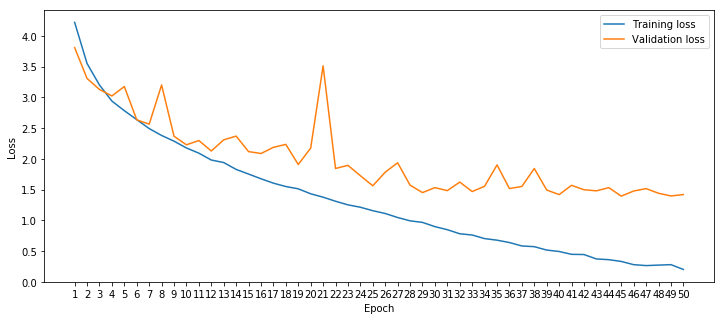

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,5))
epoch_list = np.arange(1, num_epochs+1)
plt.xticks(epoch_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epoch_list, train_losses, label="Training loss")
plt.plot(epoch_list, val_losses, label="Validation loss")
plt.legend(loc='upper right')
plt.show()

In [6]:
model.eval()

correct = 0
with torch.no_grad():
    for _, batch in enumerate(test_loader):
        data = batch['image'].to(device)
        labels = batch['label'].long().to(device)
        result = model(data)
        pred = result.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
    
print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset), 
                                                       100. * correct / len(test_loader.dataset)))   


Test set: Accuracy: 1011/1639 (62%)

